<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/ProDiMES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [101]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

##Read data

In [102]:
filename = 'data.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

In [103]:
data = loadmat(file_path)

efs_output_c = data['efs_output_c']
efs_output_to = data['efs_output_to']
engine_params = data['engine_params']
fault_params = data['fault_params']
sensor_noise = data['sensor_noise']

In [104]:
engines, flights, variables = efs_output_c.shape

efs_output_c_flat = efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, efs_output_c_flat))
efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [105]:
efs_output_c_df.head()

,engine,flight,Nf_c,Nc_c,P24_c,Ps30_c,T24_c,T30_c,T48_c,Wf_c,P2_c,T2_c,Pamb_c
0,1.0,1.0,1859.595832,7715.833535,8.037635,113.953906,500.853842,1178.331435,1465.060327,1.142543,5.139235,433.027482,3.339920
1,1.0,2.0,1810.447129,7751.359782,8.529601,115.034972,513.242330,1190.407996,1461.859352,1.137586,5.747159,451.041562,3.923802
2,1.0,3.0,1820.849278,7673.413100,7.655241,106.664922,497.614161,1165.979747,1443.481583,1.055707,5.023991,433.767442,3.417812
3,1.0,4.0,1833.791353,7641.288490,7.756760,110.829340,489.877691,1156.270536,1437.989161,1.099418,4.991406,424.458140,3.427674
4,1.0,5.0,1830.194811,7649.170919,7.938302,111.945776,492.987600,1159.236156,1437.390716,1.106730,5.138531,427.878730,3.443684


In [106]:
engines, flights, variables = efs_output_to.shape

efs_output_to_flat = efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, efs_output_to_flat))
efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [107]:
efs_output_to_df.head()

,engine,flight,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,1.0,1.0,2339.271150,9045.702711,27.306823,477.686281,650.431031,1593.794706,2112.627387,6.401851,14.775466,532.445661,14.300201
1,1.0,2.0,2413.507949,9142.554805,24.424444,438.554748,658.386937,1624.018085,2174.999886,6.043534,12.641754,531.430147,12.182256
2,1.0,3.0,2371.600299,9182.835564,27.313581,476.874091,670.662587,1637.445975,2175.000255,6.524660,14.818824,549.451189,14.354735
3,1.0,4.0,2399.100305,9155.317170,24.016622,426.993045,662.338715,1628.054256,2174.999800,5.871794,12.636289,537.449542,12.166091
4,1.0,5.0,2331.950449,9017.499406,27.380540,479.045321,646.365264,1584.872687,2099.762407,6.391934,14.815391,529.118320,14.340751


In [108]:
engines, flights, params = engine_params.shape

engine_params_flat = engine_params.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, engine_params_flat))
engine_params_df = pd.DataFrame(data, columns=engine_params_columns)

In [109]:
engine_params_df.head()

,engine,flight,altitude_to,mach_to,dTamb_to,NfR_to,altitude_c,mach_c,dTamb_c,Fn_c,fan_eff,fan_fc,lpc_eff,lpc_fc,hpc_eff,hpc_fc,hpt_eff,hpt_fc,lpt_eff,lpt_fc
0,1.0,1.0,753.542747,0.226406,11.059727,2339.271150,35727.931768,0.811416,-8.616973,6475.757322,-1.521502,-1.031776,-0.608823,-0.983948,-1.944067,-2.229537,-0.818469,0.480494,0.021486,0.092161
1,1.0,2.0,5099.630838,0.239818,24.902952,2417.195916,32312.660182,0.761073,0.776824,6147.686476,-1.521887,-1.032272,-0.609011,-0.984416,-1.944421,-2.230300,-0.818723,0.480665,0.021445,0.092181
2,1.0,3.0,648.722908,0.223596,27.655032,2376.333974,35245.636378,0.764815,-4.641804,6011.885897,-1.522272,-1.032767,-0.609200,-0.984884,-1.944775,-2.231064,-0.818977,0.480837,0.021404,0.092201
3,1.0,4.0,5135.081578,0.242501,30.844399,2430.846897,35185.213054,0.754971,-12.170908,6556.597869,-1.522658,-1.033263,-0.609389,-0.985352,-1.945129,-2.231830,-0.819231,0.481008,0.021363,0.092221
4,1.0,5.0,675.570560,0.225981,7.508015,2331.950449,35087.411483,0.780340,-12.116359,6385.635817,-1.523043,-1.033758,-0.609578,-0.985820,-1.945483,-2.232596,-0.819485,0.481179,0.021321,0.092241


In [110]:
fault_params_df = pd.DataFrame(fault_params, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

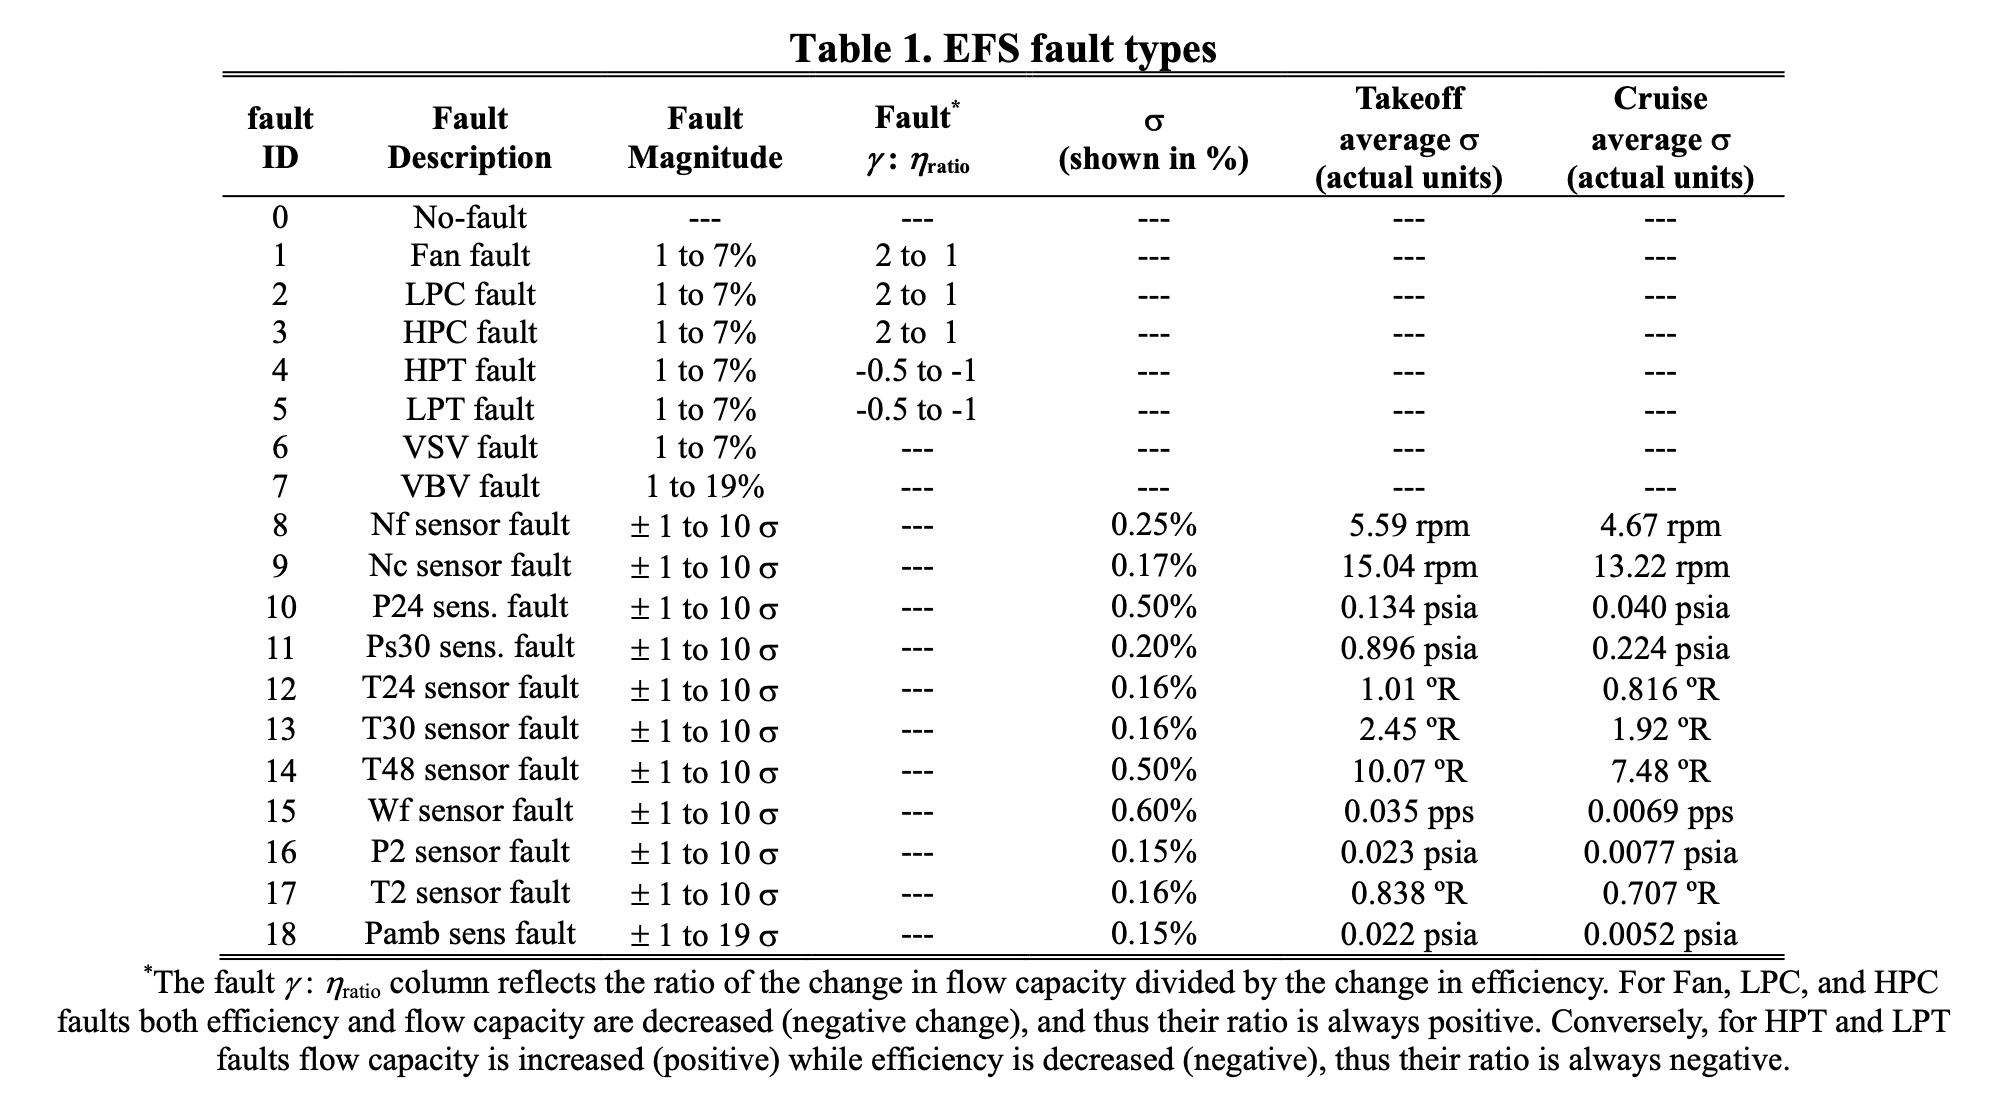

In [111]:
fault_params_df = fault_params_df.rename_axis("engine")

In [112]:
fault_params_df.head()

,fault_id,fligh_initiation,fault_ev_rate,fault_magnitude,fc_eff_ratio
engine,,,,,
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


## Visualize Data

In [113]:
def visualize_param(dataset,engine, ysensor,xsensor):
  y_values = dataset[dataset['engine'] == engine][[ysensor]]
  x_values = dataset[dataset['engine'] == engine][[xsensor]]

  plt.figure(figsize=(8, 6))  # Set the figure size
  plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.xlabel(x_values.columns[0])
  plt.ylabel(y_values.columns[0])
  plt.title(label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.legend()
  plt.grid(True)

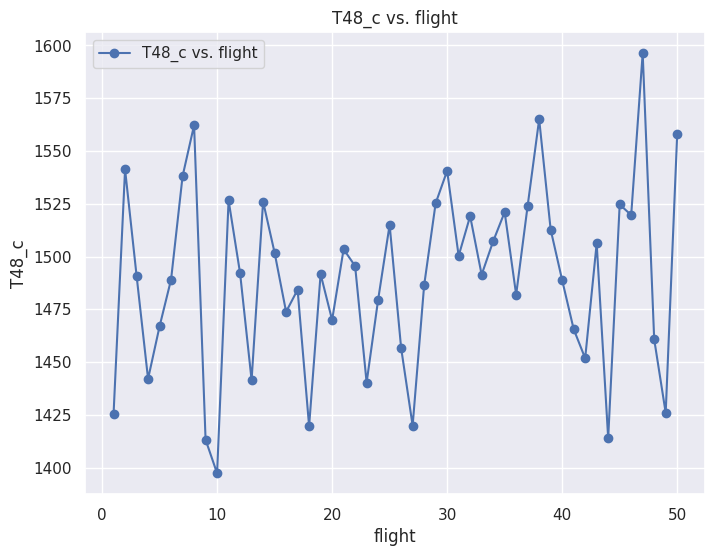

In [114]:
visualize_param(efs_output_c_df,88,"T48_c","flight")

In [115]:
def scatter_values(dataset, engines, ysensor, xsensor, fault_df=fault_params_df):
    fault_df = fault_df.reset_index()

    subset = dataset[dataset['engine'].isin(engines)]

    subset = subset.merge(fault_df[['engine', 'fault_id']], on='engine', how='left')

    fault_ids = subset['fault_id'].unique()
    colors = plt.cm.tab10(range(len(fault_ids)))
    fault_colors = {fault_id: colors[i] for i, fault_id in enumerate(fault_ids)}

    plt.figure(figsize=(10, 7))
    for fault_id, color in fault_colors.items():
        fault_subset = subset[subset['fault_id'] == fault_id]
        plt.scatter(
            fault_subset[xsensor], fault_subset[ysensor],
            color=color, label=f'Fault ID {fault_id}', alpha=0.8
        )

    plt.xlabel(xsensor)
    plt.ylabel(ysensor)
    plt.title(f'{ysensor} vs. {xsensor} by Fault Type')
    plt.legend()
    plt.grid(True)
    plt.show()

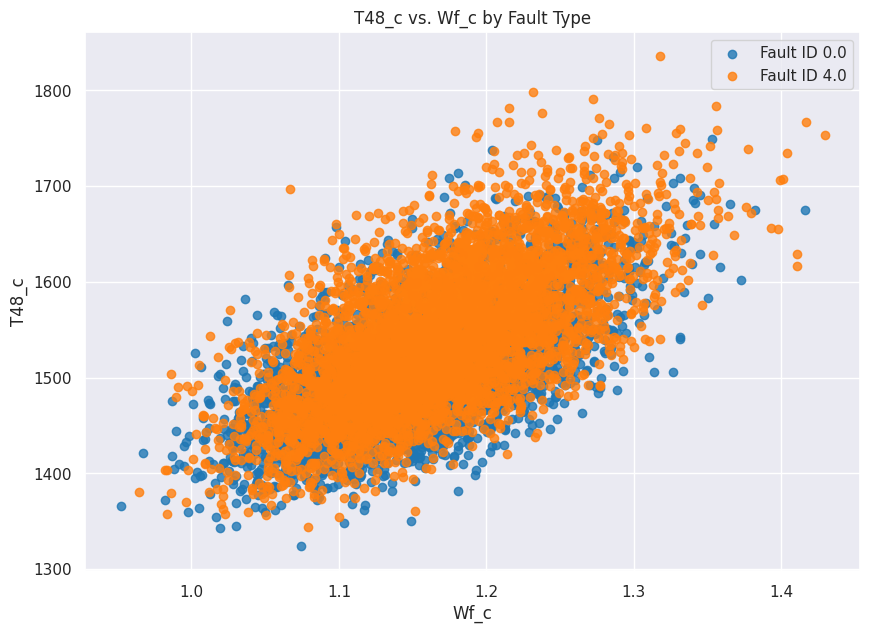

In [116]:
faults = [0,4]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(efs_output_c_df,engines,"T48_c","Wf_c",fault_params_df)

##Data pre-processing

###Baseline

Tentar de dois jeitos:
1. interpolação com dados gerados pelo CMAPSS-SS
2. Rede Neural que faz a estimativa

1. Interpolação com dados gerados pelo CMAPSS-SS

In [117]:
file1 = 'EFS_fault_conditions_health.mat'
file2 = 'EFS_operating_conditions_health.mat'
file3 = 'EFS_Output_health.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path1 = location + file1
file_path2 = location + file2
file_path3 = location + file3

data1 = loadmat(file_path1)
data2 = loadmat(file_path2)
data3 = loadmat(file_path3)

health_efs_output_c = data3['efs_output_c']
health_efs_output_to = data3['efs_output_to']
health_engine_params = data2['engine_params']
health_fault_params = data1['fault_params']
health_sensor_noise = data2['sensor_noise']

In [118]:
health_efs_output_c.shape

(100, 90, 11)

In [119]:
engines, flights, variables = health_efs_output_c.shape

health_efs_output_c_flat = health_efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_c_flat))
health_efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [120]:
engines, flights, variables = health_efs_output_to.shape

health_efs_output_to_flat = health_efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_to_flat))
health_efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [121]:
engines, flights, params = health_engine_params.shape

health_engine_params_flat = health_engine_params.reshape(engines * flights, params)

health_engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, health_engine_params_flat))
health_engine_params_df = pd.DataFrame(data, columns=health_engine_params_columns)

In [122]:
u_to = health_engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_c = health_engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

In [123]:
y_to = health_efs_output_to_df.drop(columns=["engine","flight"])
y_c =  health_efs_output_c_df.drop(columns=["engine","flight"])

In [124]:
y_to.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,2192.553081,8764.962719,26.272345,422.263273,608.549299,1527.072893,2065.990727,5.712490,14.816205,504.008808,14.311442
1,2285.351732,8961.558306,26.910034,442.930156,631.192006,1590.269974,2175.000904,6.251980,14.592050,515.989674,14.131321
2,2157.871399,8631.145306,26.231978,422.830648,589.515879,1484.714016,2004.436747,5.599660,14.794735,488.190149,14.353818
3,2279.530225,8896.933909,27.332680,453.226359,620.582363,1569.644310,2148.169670,6.349092,14.669274,505.597448,14.216008
4,2195.911004,8780.272071,26.295601,422.932312,610.493531,1531.997975,2073.785761,5.738334,14.827145,505.553782,14.363081


In [125]:
models_to = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_to.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_to, y_to[column])

    models_to[column] = pipeline


In [126]:
models_c = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_c.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_c, y_c[column])

    models_c[column] = pipeline

In [127]:
#now estimate for the parameters of the original dataset
u_orig_to = engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c = engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to = {}
for column, model in models_to.items():
    health_y_to[column] = model.predict(u_orig_to)

health_y_c = {}
for column, model in models_c.items():
    health_y_c[column] = model.predict(u_orig_c)

health_y_to_df = pd.DataFrame(health_y_to)
health_y_c_df = pd.DataFrame(health_y_c)

In [128]:
health_y_to_df.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to
0,2333.339161,9036.437033,27.290385,469.998261,650.200891,1593.389173,2119.971051,6.339569,14.775508,532.445766,14.300242
1,2382.677301,9097.843414,24.062990,423.933270,654.837601,1610.749785,2150.252727,5.781446,12.641624,531.430208,12.182149
2,2345.057997,9140.515678,27.004860,461.246866,667.737601,1625.598708,2159.563980,6.290000,14.818883,549.451424,14.354787
3,2383.172719,9131.204923,23.874291,418.264346,660.655465,1621.335528,2163.550255,5.726383,12.636185,537.449494,12.166014
4,2329.039201,9013.301560,27.408565,472.467571,646.536602,1586.166225,2110.569776,6.355447,14.815439,529.118362,14.340797


In [129]:
deviation_to = {}
for column in efs_output_to_df.columns[2:]:
  deviation_to[column] = (efs_output_to_df[column] - health_y_to_df[column])/health_y_to_df[column]

deviation_c = {}
for column in efs_output_c_df.columns[2:]:
  deviation_c[column] = (efs_output_c_df[column] - health_y_c_df[column])/health_y_c_df[column]


deviation_to_df = pd.DataFrame(deviation_to)
deviation_c_df = pd.DataFrame(deviation_c)

In [130]:
deviation_c_df["engine"] = efs_output_c_df["engine"]
deviation_c_df["flight"] = efs_output_c_df["flight"]

In [131]:
deviation_to_df["engine"] = efs_output_to_df["engine"]
deviation_to_df["flight"] = efs_output_to_df["flight"]

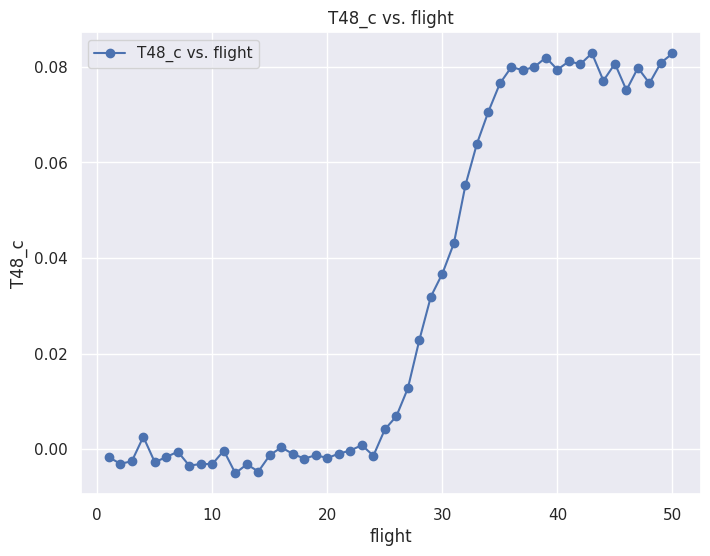

In [132]:
visualize_param(deviation_c_df,440,"T48_c","flight")

In [133]:
#note that for first 10 flights (health engine) deviation is higher than 0.
#Next step is to adjust the general model to consider specific engine characteristics

#first 10 flights are healthy conditions
def calculate_average_deviation(deviation_df):
    average_deviation = (
        deviation_df.groupby('engine')
        .apply(lambda group: group.iloc[:10, :-2].mean())
        .reset_index()
    )
    return average_deviation

average_deviation_to_df = calculate_average_deviation(deviation_to_df)
average_deviation_c_df = calculate_average_deviation(deviation_c_df)

<ipython-input-133-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())
<ipython-input-133-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())


In [134]:
average_deviation_c_df.head()

,engine,Nf_c,Nc_c,P24_c,Ps30_c,T24_c,T30_c,T48_c,Wf_c,P2_c,T2_c,Pamb_c
0,1.0,-0.002920,-0.001158,-0.003752,0.006776,-0.001425,-0.003983,-0.010779,-0.007415,0.000024,0.000087,0.000018
1,2.0,0.001153,0.002728,-0.000984,-0.012053,0.001419,0.006992,0.024352,0.022919,-0.000043,0.000292,-0.000010
2,3.0,0.000083,-0.000658,0.000192,-0.000258,0.000569,-0.002584,-0.002422,-0.001426,0.000029,0.000309,0.000011
3,4.0,-0.000006,-0.001670,0.001540,-0.003295,0.000858,-0.003175,0.000917,0.000149,-0.000098,0.000245,-0.000032
4,5.0,-0.001619,-0.002429,-0.001167,0.005777,-0.001229,-0.007447,-0.016992,-0.015980,0.000032,0.000234,0.000006


In [135]:
health_y_c_df["flight"] = efs_output_c_df["flight"]
health_y_c_df["engine"] = efs_output_c_df["engine"]

health_y_to_df["flight"] = efs_output_to_df["flight"]
health_y_to_df["engine"] = efs_output_to_df["engine"]

In [136]:
def update_health_conditions(health_y_df, avg_deviation_df, deviation_columns):
    updated_health_y_df = health_y_df.copy()

    for engine in avg_deviation_df['engine']:

        engine_avg_deviation = avg_deviation_df[avg_deviation_df['engine'] == engine][deviation_columns].iloc[0]

        engine_mask = (health_y_df['engine'] == engine)
        for column in deviation_columns:
            updated_health_y_df.loc[engine_mask, column] *= (1 + engine_avg_deviation[column])

    return updated_health_y_df

updated_health_y_to_df = update_health_conditions(health_y_to_df, average_deviation_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df = update_health_conditions(health_y_c_df, average_deviation_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)

In [137]:
updated_health_y_to_df.head()

,Nf_to,Nc_to,P24_to,Ps30_to,T24_to,T30_to,T48_to,Wf_to,P2_to,T2_to,Pamb_to,flight,engine
0,2346.116394,9054.477660,27.410289,479.734887,651.351899,1597.139402,2121.769625,6.462371,14.775532,532.445684,14.300252,1.0,1.0
1,2395.724706,9116.006634,24.168714,432.715600,655.996816,1614.540875,2152.076992,5.893437,12.641645,531.430126,12.182158,2.0,1.0
2,2357.899401,9158.764091,27.123510,470.802195,668.919653,1629.424746,2161.396144,6.411841,14.818908,549.451340,14.354797,3.0,1.0
3,2396.222837,9149.434748,23.979186,426.929236,661.824979,1625.151533,2165.385801,5.837307,12.636206,537.449412,12.166023,4.0,1.0
4,2341.792887,9031.295998,27.528987,482.255352,647.681123,1589.899454,2112.360374,6.478557,14.815463,529.118281,14.340807,5.0,1.0


In [138]:
def calculate_final_deviations(observed_df, updated_health_y_df, deviation_columns):
    final_deviation_df = pd.DataFrame()
    for column in deviation_columns:
        final_deviation_df[column] = (observed_df[column] - updated_health_y_df[column]) / updated_health_y_df[column]
    return final_deviation_df

final_deviation_to_df = calculate_final_deviations(efs_output_to_df, updated_health_y_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
final_deviation_c_df = calculate_final_deviations(efs_output_c_df, updated_health_y_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)


In [139]:
final_deviation_to_df["engine"] = efs_output_to_df["engine"]
final_deviation_to_df["flight"] = efs_output_to_df["flight"]

final_deviation_c_df["engine"] = efs_output_c_df["engine"]
final_deviation_c_df["flight"] = efs_output_c_df["flight"]

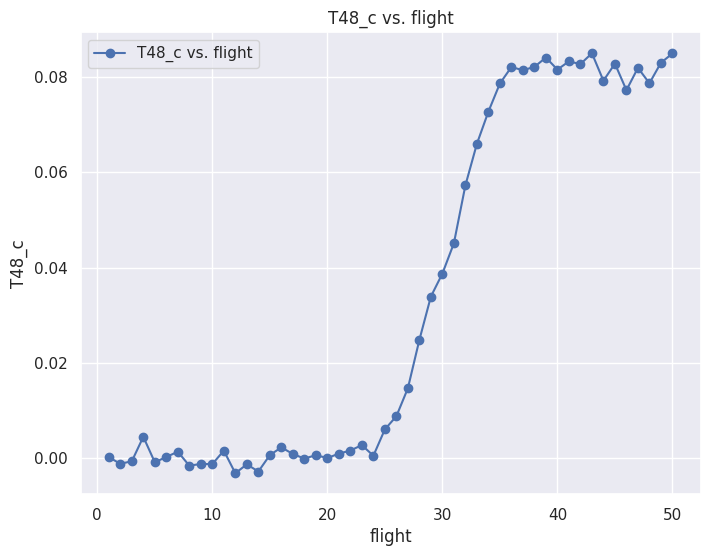

In [140]:
visualize_param(final_deviation_c_df,440,"T48_c","flight")

2. Rede Neural (TBD)

In [141]:
#TBD

###Trend Monitoring

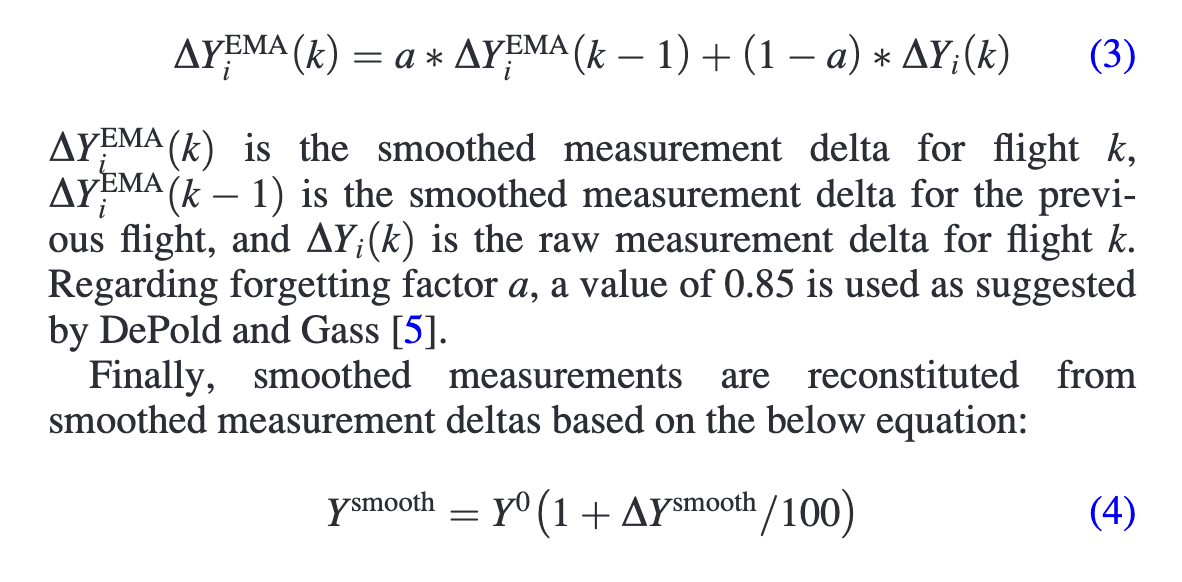

In [142]:
#implement exponential moving average to smooth data
alpha = 0.85 #prodimes user guide uses 0.8844
def apply_exponential_moving_average(df, alpha, deviation_columns):
  ema_data = df[['engine', 'flight']].copy()

  for column in deviation_columns:
      if column not in df.columns:
          raise KeyError(f"Column '{column}' not found in the DataFrame!")

      ema_values = []

      for engine_id in df['engine'].unique():

          engine_data = df[df['engine'] == engine_id]

          if engine_data.empty:
              print(f"Warning: No data found for engine {engine_id}.")
              continue

          ema = engine_data[column].iloc[0]
          ema_values_engine = [ema]

          for k in range(1, len(engine_data)):
              delta_y = engine_data[column].iloc[k]
              ema = alpha * ema + (1 - alpha) * delta_y
              ema_values_engine.append(ema)

          ema_values.extend(ema_values_engine)

      ema_data[f'{column}_ema'] = ema_values

  return ema_data

deviation_columns_to = final_deviation_to_df.drop(columns=['engine', 'flight']).columns

deviation_columns_c = final_deviation_c_df.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df = apply_exponential_moving_average(final_deviation_to_df, alpha, deviation_columns_to)
ema_health_y_c_df = apply_exponential_moving_average(final_deviation_c_df, alpha, deviation_columns_c)

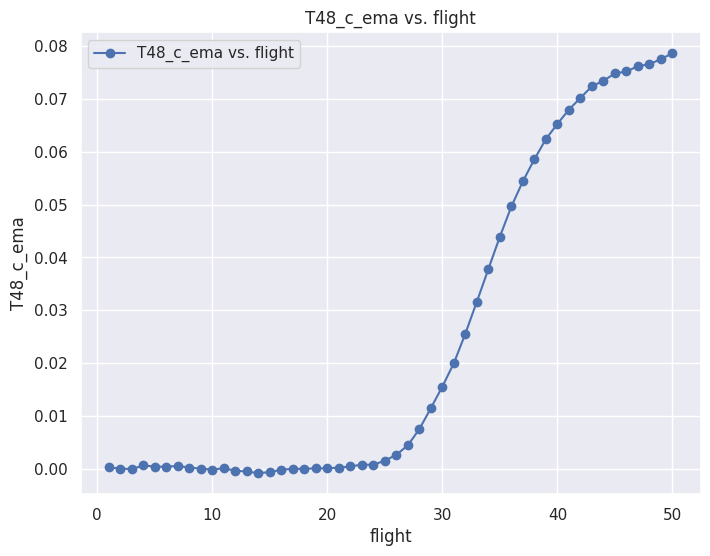

In [143]:
visualize_param(ema_health_y_c_df,440,"T48_c_ema","flight")

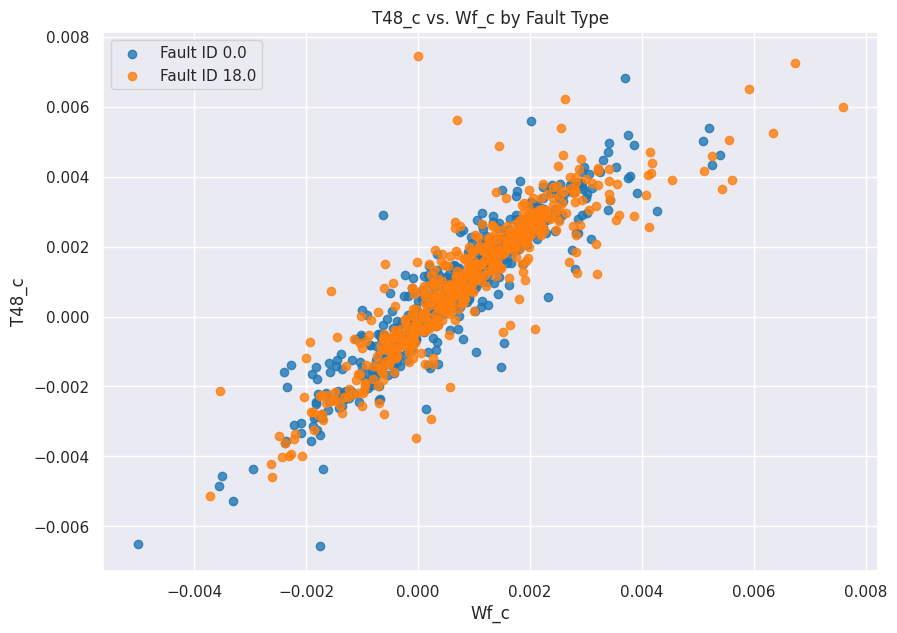

In [144]:
faults = [0,18]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(final_deviation_c_df.query('flight > 45'),engines,"T48_c","Wf_c",fault_params_df)

## Fault Identification & Classification

###Training and validation data treatment

In [229]:
#testing without take off data
#data_total = pd.merge(ema_health_y_to_df, ema_health_y_c_df, on=['engine', 'flight'])
data_total = ema_health_y_c_df

In [230]:
data_total.head()

,engine,flight,Nf_c_ema,Nc_c_ema,P24_c_ema,Ps30_c_ema,T24_c_ema,T30_c_ema,T48_c_ema,Wf_c_ema,P2_c_ema,T2_c_ema,Pamb_c_ema
0,1.0,1.0,-0.001187,-0.000926,-0.000466,-0.000446,-0.002005,-0.001777,-0.001468,-0.000773,-0.000279,-0.001904,-0.000019
1,1.0,2.0,-0.001135,-0.000847,-0.000397,-0.000485,-0.001886,-0.001610,-0.001343,-0.000831,-0.000267,-0.001800,-0.000025
2,1.0,3.0,-0.000985,-0.000756,-0.000303,-0.000439,-0.001643,-0.001406,-0.001152,-0.000707,-0.000220,-0.001588,-0.000020
3,1.0,4.0,-0.000895,-0.000663,-0.000299,-0.000358,-0.001441,-0.001287,-0.001107,-0.000703,-0.000187,-0.001374,-0.000014
4,1.0,5.0,-0.000727,-0.000554,-0.000225,-0.000291,-0.001204,-0.001067,-0.000870,-0.000508,-0.000146,-0.001162,-0.000009


In [231]:
def createlabel(df,fault_param):
  label = {}
  for engine in df['engine'].unique():
    if engine not in fault_param.index:
      print(f"Warning: Engine {engine} not found in fault_param. Skipping.")
      continue  # Skip engines that are not in fault_param
    flight_init = fault_param.loc[engine]['fligh_initiation']
    fault_id = fault_param.loc[engine]['fault_id']

    for flight in df[df['engine'] == engine]['flight']:
      if flight < flight_init:
        label[(engine,flight)] = 0
      else:
        label[(engine,flight)] = fault_id
  return label


In [232]:
fault_label = createlabel(data_total,fault_params_df)

In [233]:
fault_label_df = (
    pd.DataFrame.from_dict(fault_label, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df[['engine', 'flight']] = pd.DataFrame(fault_label_df['index'].tolist(), index=fault_label_df.index)
fault_label_df = fault_label_df.drop(columns=['index'])

data_total_with_labels = pd.merge(data_total, fault_label_df, on=['engine', 'flight'], how='left')

In [234]:
data_total_with_labels.head()

,engine,flight,Nf_c_ema,Nc_c_ema,P24_c_ema,Ps30_c_ema,T24_c_ema,T30_c_ema,T48_c_ema,Wf_c_ema,P2_c_ema,T2_c_ema,Pamb_c_ema,fault_label
0,1.0,1.0,-0.001187,-0.000926,-0.000466,-0.000446,-0.002005,-0.001777,-0.001468,-0.000773,-0.000279,-0.001904,-0.000019,0.0
1,1.0,2.0,-0.001135,-0.000847,-0.000397,-0.000485,-0.001886,-0.001610,-0.001343,-0.000831,-0.000267,-0.001800,-0.000025,0.0
2,1.0,3.0,-0.000985,-0.000756,-0.000303,-0.000439,-0.001643,-0.001406,-0.001152,-0.000707,-0.000220,-0.001588,-0.000020,0.0
3,1.0,4.0,-0.000895,-0.000663,-0.000299,-0.000358,-0.001441,-0.001287,-0.001107,-0.000703,-0.000187,-0.001374,-0.000014,0.0
4,1.0,5.0,-0.000727,-0.000554,-0.000225,-0.000291,-0.001204,-0.001067,-0.000870,-0.000508,-0.000146,-0.001162,-0.000009,0.0


In [235]:
data_total_with_labels = data_total_with_labels.dropna(subset=['fault_label'])

In [236]:
X = data_total_with_labels.drop(columns=['engine', 'flight', 'fault_label'])
y = data_total_with_labels['fault_label']

#in the future it will be better to make a subset of full flights for each engine for all fault scenarios

In [237]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

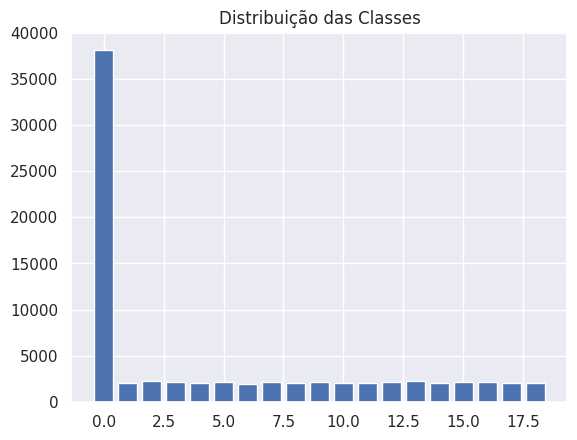

In [238]:
plt.bar(np.unique(y_train), np.bincount(y_train))
plt.title('Distribuição das Classes')
plt.show()

In [239]:
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (75800, 11)
X_test shape :  (18950, 11)
y_train shape :  (75800,)
y_test shape :  (18950,)


In [240]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Classification Algorithms

In [213]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

num_classes = len(y_train.unique())
if num_classes > 2:  # Multiclass classification
    y_train_encoded = to_categorical(y_train, num_classes=num_classes)
    y_test_encoded = to_categorical(y_test, num_classes=num_classes)
else:
    y_train_encoded = y_train
    y_test_encoded = y_test

# Define the neural network
model_ANN = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')  # Output layer
])

# Compile the model
model_ANN.compile(
    optimizer='adam',
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_ANN.fit(
    X_train, y_train_encoded,
    epochs=15,  # Adjust epochs as needed
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model_ANN.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2369/2369 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6521 - loss: 1.4919 - val_accuracy: 0.7918 - val_loss: 0.8753
Epoch 2/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7717 - loss: 0.9380 - val_accuracy: 0.8026 - val_loss: 0.8233
Epoch 3/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7873 - loss: 0.8871 - val_accuracy: 0.8062 - val_loss: 0.8015
Epoch 4/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7966 - loss: 0.8582 - val_accuracy: 0.8062 - val_loss: 0.7939
Epoch 5/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8005 - loss: 0.8433 - val_accuracy: 0.8068 - val_loss: 0.7860
Epoch 6/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7996 - loss: 0.8422 - val_accuracy: 0.8072 - val_loss: 0.7772
Epoch 7/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8037 - loss: 0.8277 - val_accuracy: 0.8075 - val_loss: 0.7754
Epoch 8/15
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8033 - loss: 0.8240 - val_accur

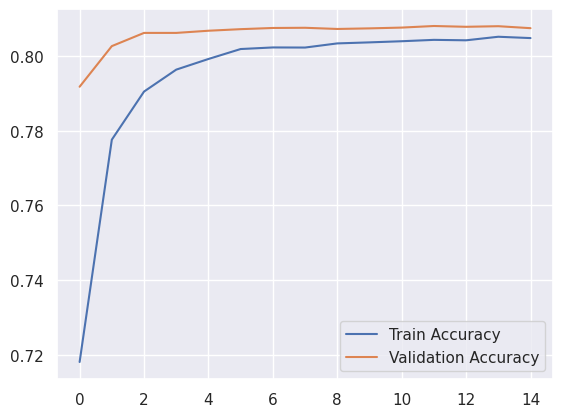

In [214]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


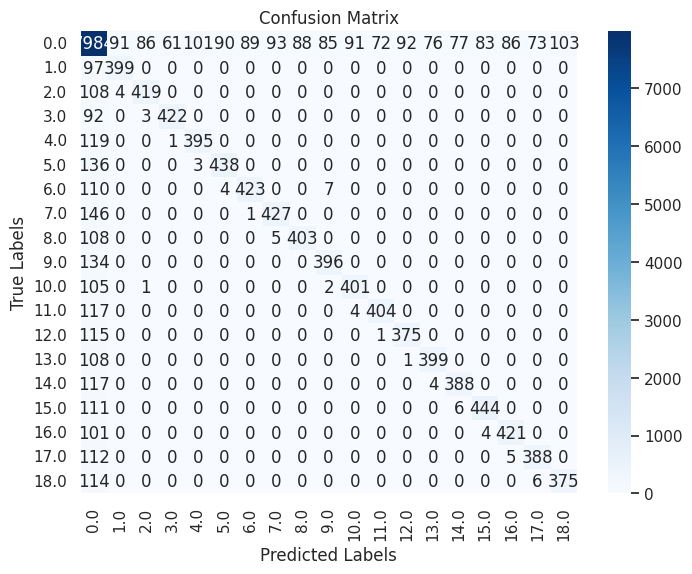

In [215]:
y_pred = model_ANN.predict(X_test)

y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [244]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler

X_train_array = X_train
X_test_array = X_test

# Fazer o reshape
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

#one hot encode
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Define the CNN model
model_CNN = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=1, activation='relu'),
    BatchNormalization(),
    #MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_CNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_CNN.fit(
    X_train_reshaped, y_train_encoded,
    epochs=30,  # Adjust epochs as needed
    batch_size=32,
    validation_data=(X_test_reshaped, y_test_encoded),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model_CNN.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.7122 - loss: 1.2220 - val_accuracy: 0.7812 - val_loss: 0.8987
Epoch 2/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - accuracy: 0.7721 - loss: 0.9648 - val_accuracy: 0.7869 - val_loss: 0.9002
Epoch 3/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7782 - loss: 0.9270 - val_accuracy: 0.7881 - val_loss: 0.9034
Epoch 4/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.7776 - loss: 0.9171 - val_accuracy: 0.7868 - val_loss: 0.8723
Epoch 5/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7780 - loss: 0.9113 - val_accuracy: 0.7814 - val_loss: 0.8454
Epoch 6/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7823 - loss: 0.9012 - val_accuracy: 0.7897 - val_loss: 0.8424
Epoch 7/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7805 - loss: 0.8930 - val_accuracy: 0.7865 - val_loss: 0.8676
Epoch 8/30
2369/2369 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.7816 - loss: 

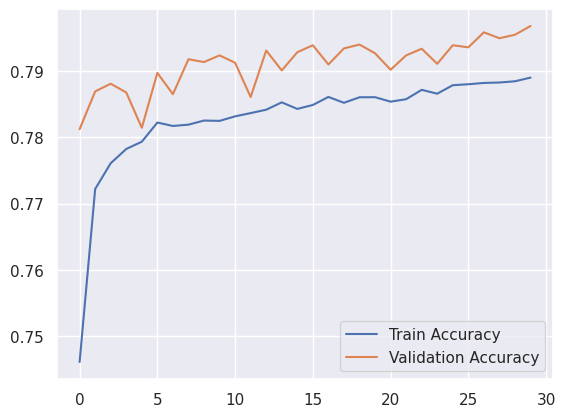

In [245]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


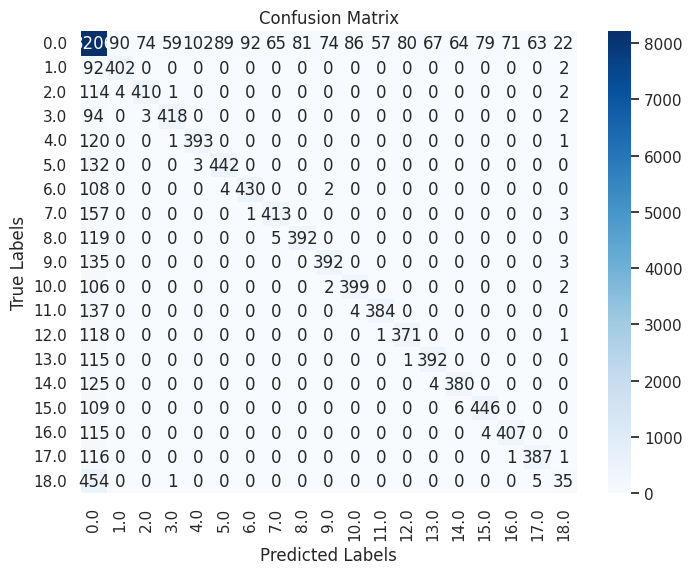

In [246]:
y_pred = model_CNN.predict(X_test)

y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [162]:
y_pred

array([[4.8775379e-02, 1.2109895e-08, 1.9920397e-07, ..., 1.9157922e-10,
        6.6479722e-10, 2.5063826e-10],
       [9.3424463e-01, 6.3373144e-03, 2.0450214e-03, ..., 9.3951384e-03,
        1.9380024e-03, 2.7036704e-03],
       [1.2251366e-01, 9.0848789e-07, 3.0644102e-08, ..., 2.1439597e-08,
        2.3284095e-08, 4.0081324e-07],
       ...,
       [7.4981564e-01, 2.9820113e-03, 1.3164130e-02, ..., 2.2233077e-03,
        6.5274341e-03, 1.4088967e-02],
       [5.3717613e-01, 3.7263140e-02, 1.7967237e-02, ..., 2.5952417e-02,
        1.0632036e-02, 2.7621057e-02],
       [1.0821022e-02, 1.4261934e-12, 7.5097560e-15, ..., 5.8540730e-15,
        1.3317552e-14, 6.0394899e-14]], dtype=float32)

## Testing with new data for evaluation

In [163]:
filename = 'data_evaluation.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

data_eval = loadmat(file_path)

efs_output_c_eval = data_eval['efs_output_c']
efs_output_to_eval = data_eval['efs_output_to']
engine_params_eval = data_eval['engine_params']
fault_params_eval = data_eval['fault_params']
sensor_noise_eval = data_eval['sensor_noise']

engines, flights, variables = efs_output_c_eval.shape

efs_output_c_flat_eval = efs_output_c_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_c_flat_eval))
efs_output_c_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [164]:
engines, flights, variables = efs_output_to_eval.shape

efs_output_to_flat_eval = efs_output_to_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_to_flat_eval))
efs_output_to_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [165]:
engines, flights, params = engine_params_eval.shape

engine_params_flat_eval = engine_params_eval.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, engine_params_flat_eval))
engine_params_df_eval = pd.DataFrame(data_eval, columns=engine_params_columns)

In [166]:
fault_params_df_eval = pd.DataFrame(fault_params_eval, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

In [167]:
fault_params_df_eval = fault_params_df_eval.rename_axis("engine")

In [168]:
u_orig_to_eval = engine_params_df_eval[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c_eval = engine_params_df_eval[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to_eval = {}
for column, model_health in models_to.items():
    health_y_to_eval[column] = model_health.predict(u_orig_to_eval)

health_y_c_eval = {}
for column, model_health in models_c.items():
    health_y_c_eval[column] = model_health.predict(u_orig_c_eval)

health_y_to_df_eval = pd.DataFrame(health_y_to_eval)
health_y_c_df_eval = pd.DataFrame(health_y_c_eval)

In [169]:
deviation_to_eval = {}
for column in efs_output_to_df_eval.columns[2:]:
  deviation_to_eval[column] = (efs_output_to_df_eval[column] - health_y_to_df_eval[column])/health_y_to_df_eval[column]

deviation_c_eval = {}
for column in efs_output_c_df_eval.columns[2:]:
  deviation_c_eval[column] = (efs_output_c_df_eval[column] - health_y_c_df_eval[column])/health_y_c_df_eval[column]


deviation_to_df_eval = pd.DataFrame(deviation_to_eval)
deviation_c_df_eval = pd.DataFrame(deviation_c_eval)

In [170]:
deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

In [171]:
average_deviation_to_df_eval = calculate_average_deviation(deviation_to_df_eval)
average_deviation_c_df_eval = calculate_average_deviation(deviation_c_df_eval)

<ipython-input-133-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())
<ipython-input-133-e4d2687681d1>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[:10, :-2].mean())


In [172]:
health_y_c_df_eval["flight"] = efs_output_c_df_eval["flight"]
health_y_c_df_eval["engine"] = efs_output_c_df_eval["engine"]

health_y_to_df_eval["flight"] = efs_output_to_df_eval["flight"]
health_y_to_df_eval["engine"] = efs_output_to_df_eval["engine"]

In [173]:
updated_health_y_to_df_eval = update_health_conditions(health_y_to_df_eval, average_deviation_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df_eval = update_health_conditions(health_y_c_df_eval, average_deviation_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [174]:
final_deviation_to_df_eval = calculate_final_deviations(efs_output_to_df_eval, updated_health_y_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
final_deviation_c_df_eval = calculate_final_deviations(efs_output_c_df_eval, updated_health_y_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [175]:
final_deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
final_deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

final_deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
final_deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

In [176]:
deviation_columns_to_eval = final_deviation_to_df_eval.drop(columns=['engine', 'flight']).columns

deviation_columns_c_eval = final_deviation_c_df_eval.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df_eval = apply_exponential_moving_average(final_deviation_to_df_eval, alpha, deviation_columns_to_eval)
ema_health_y_c_df_eval = apply_exponential_moving_average(final_deviation_c_df_eval, alpha, deviation_columns_c_eval)

In [217]:
#data_total_eval = pd.merge(ema_health_y_to_df_eval, ema_health_y_c_df_eval, on=['engine', 'flight'])
data_total_eval = ema_health_y_c_df_eval

In [218]:
fault_label_eval = createlabel(data_total_eval,fault_params_df_eval)

In [219]:
fault_label_df_eval = (
    pd.DataFrame.from_dict(fault_label_eval, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df_eval[['engine', 'flight']] = pd.DataFrame(fault_label_df_eval['index'].tolist(), index=fault_label_df_eval.index)
fault_label_df_eval = fault_label_df_eval.drop(columns=['index'])

data_total_with_labels_eval = pd.merge(data_total_eval, fault_label_df_eval, on=['engine', 'flight'], how='left')

<ipython-input-113-45fc2cbf7cc4>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))  # Set the figure size


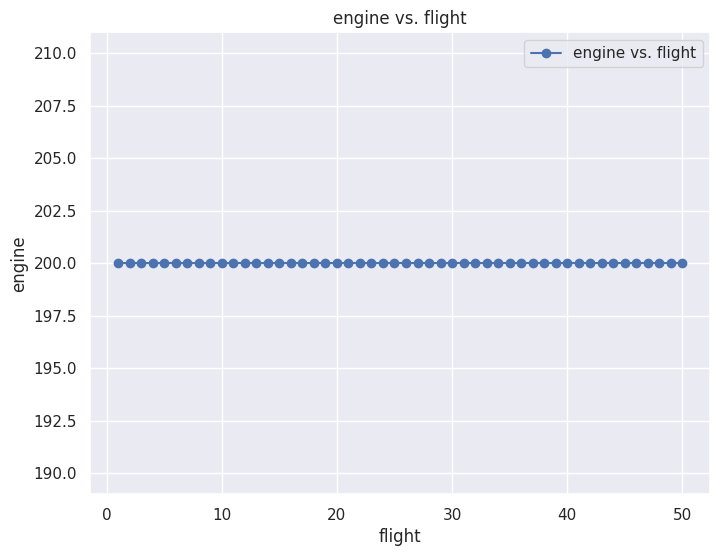

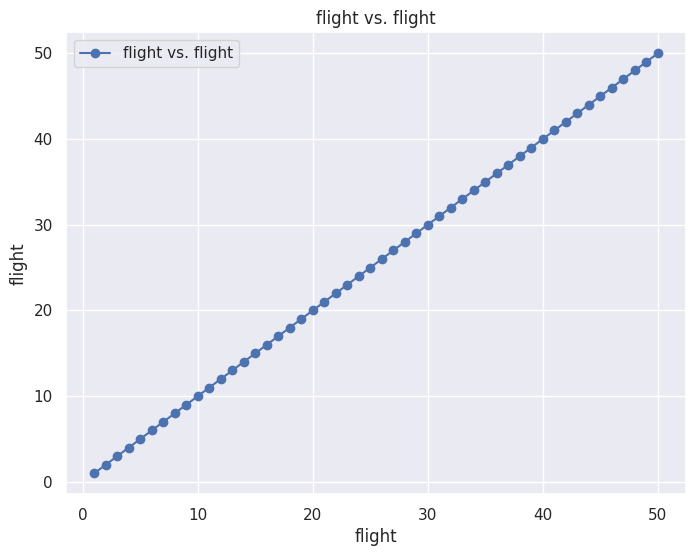

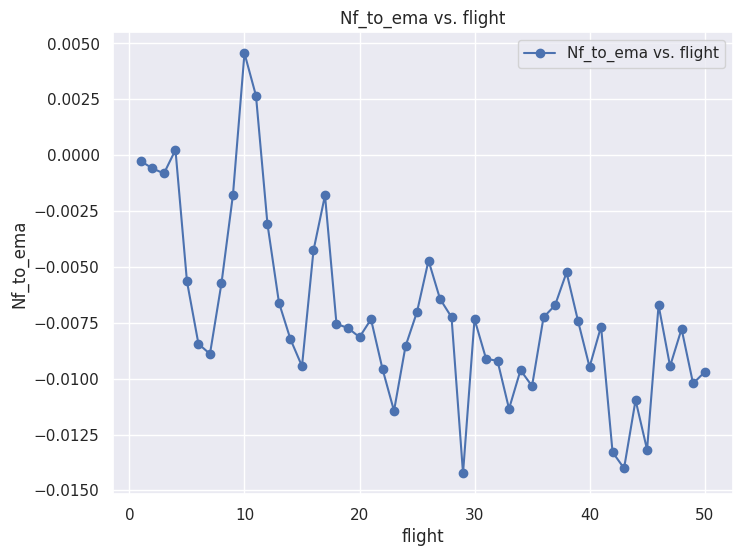

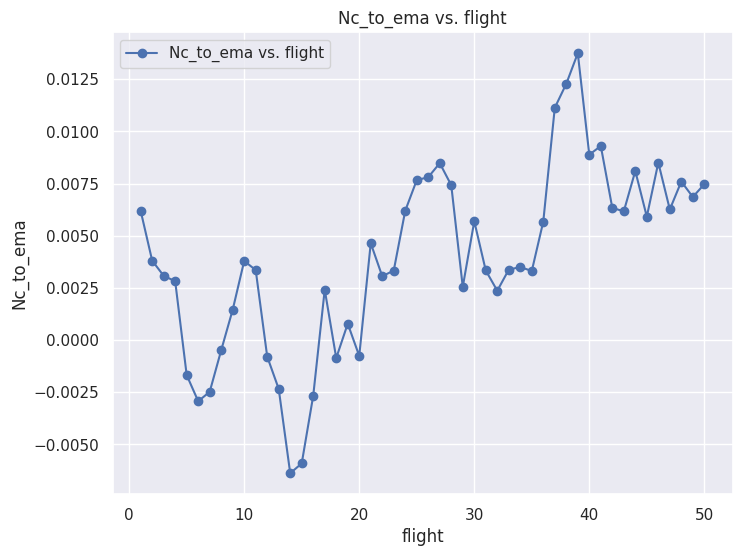

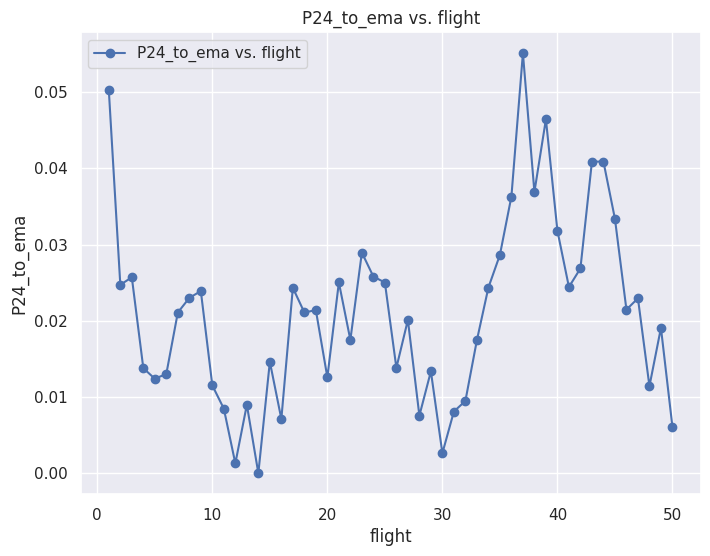

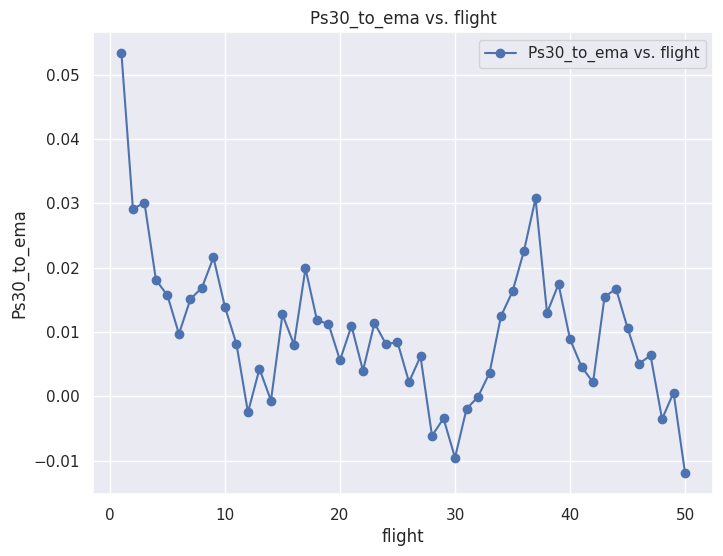

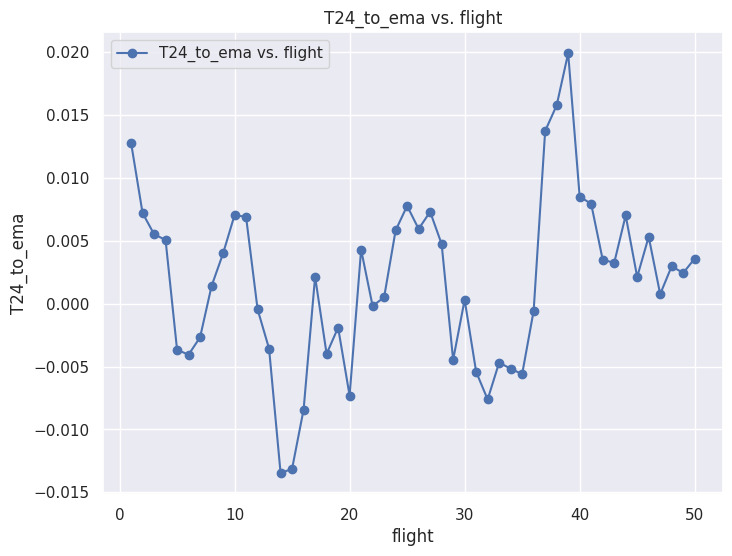

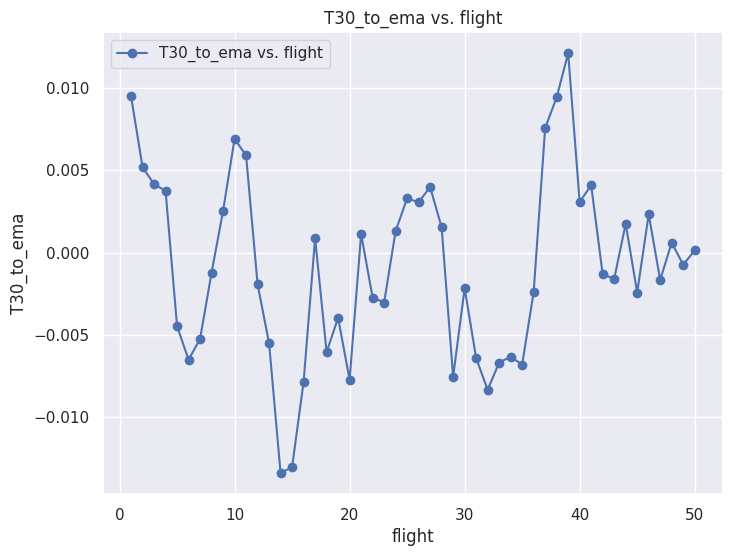

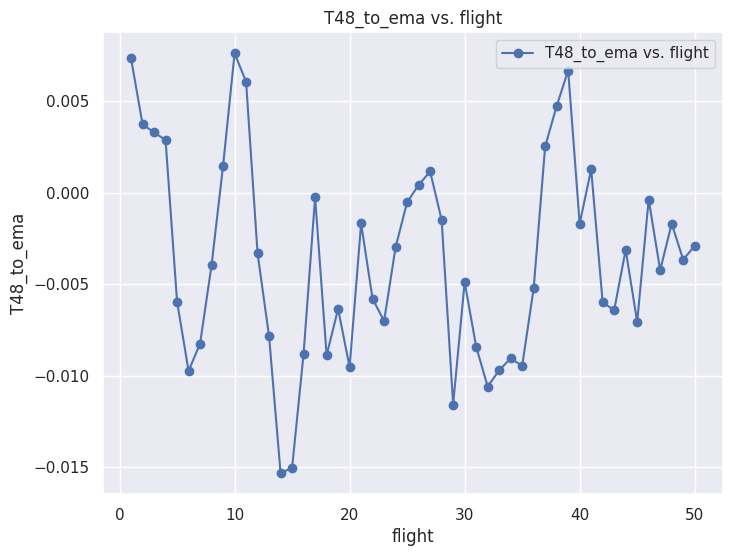

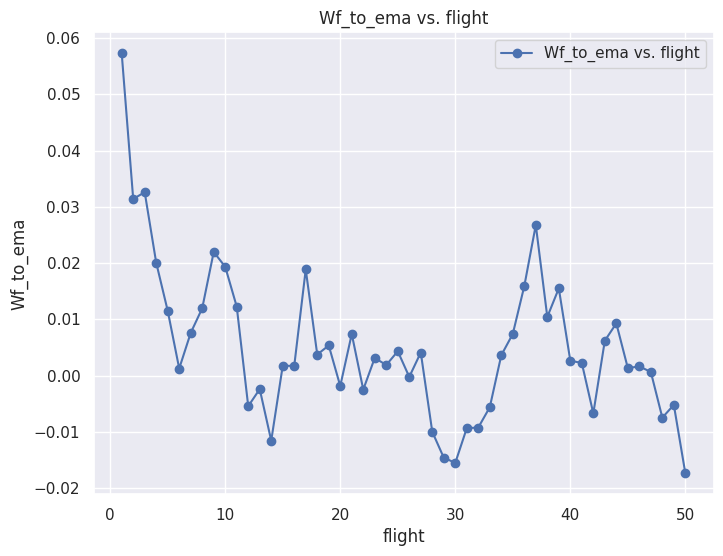

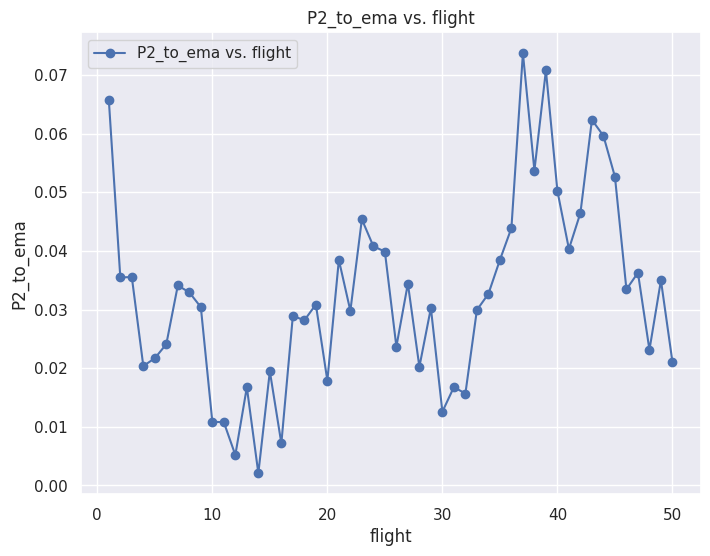

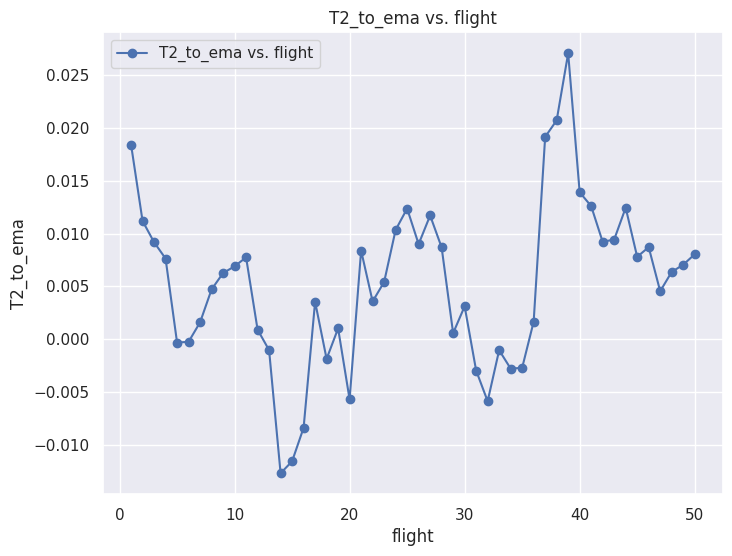

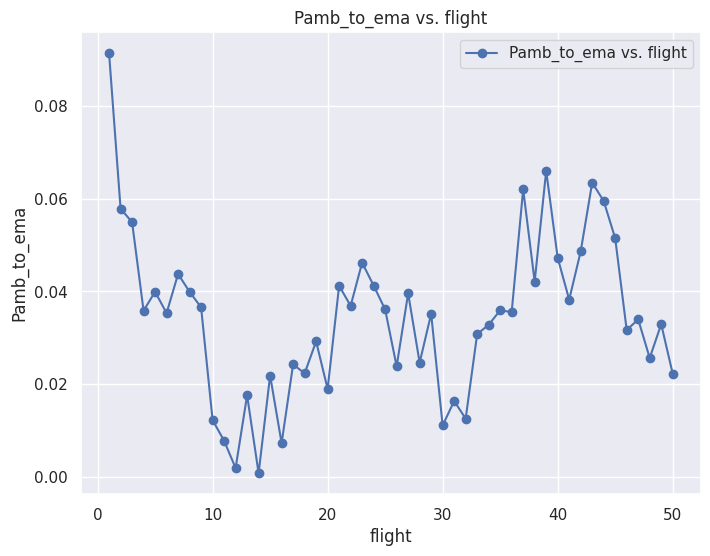

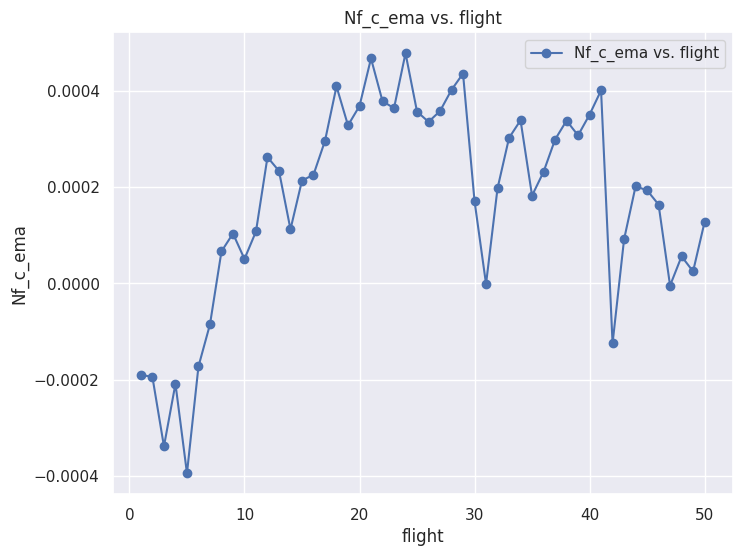

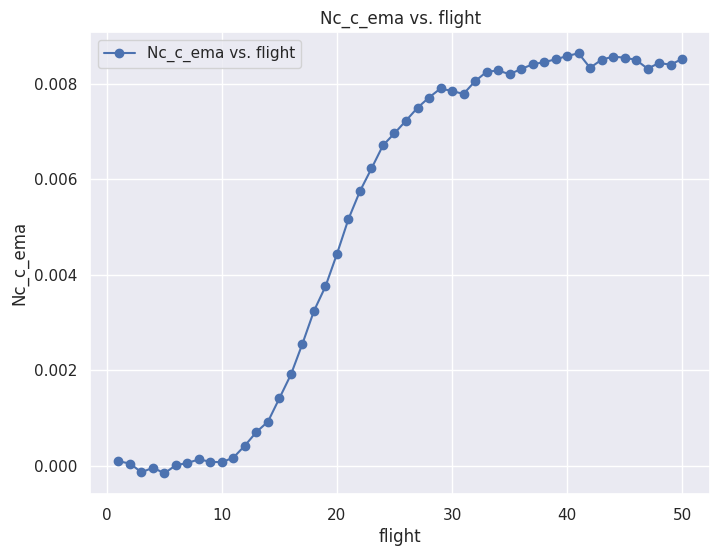

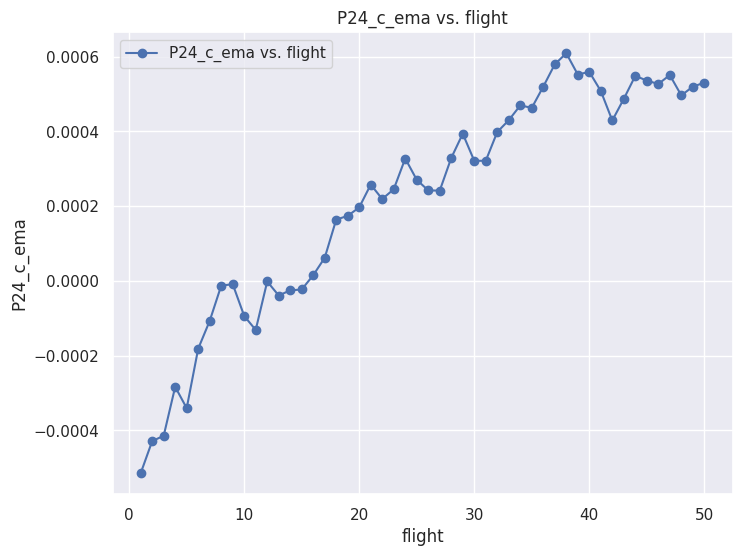

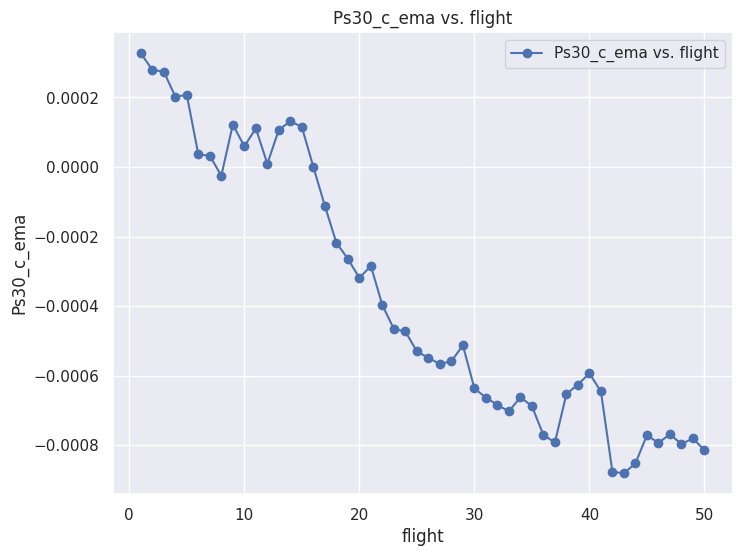

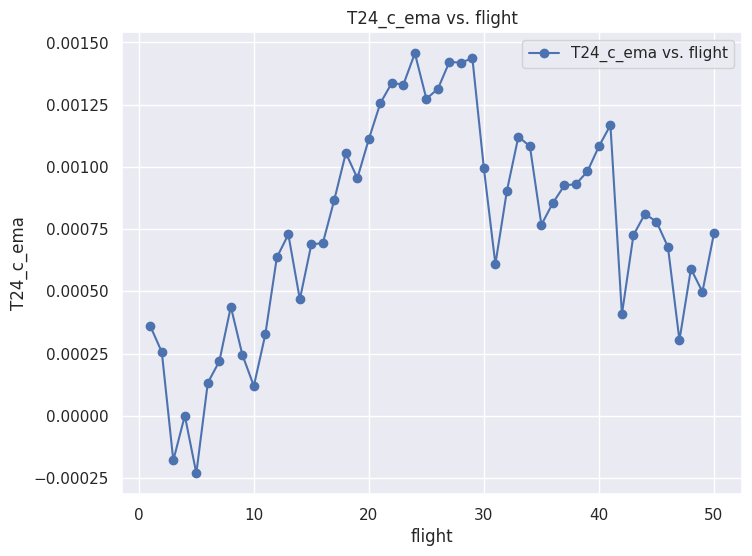

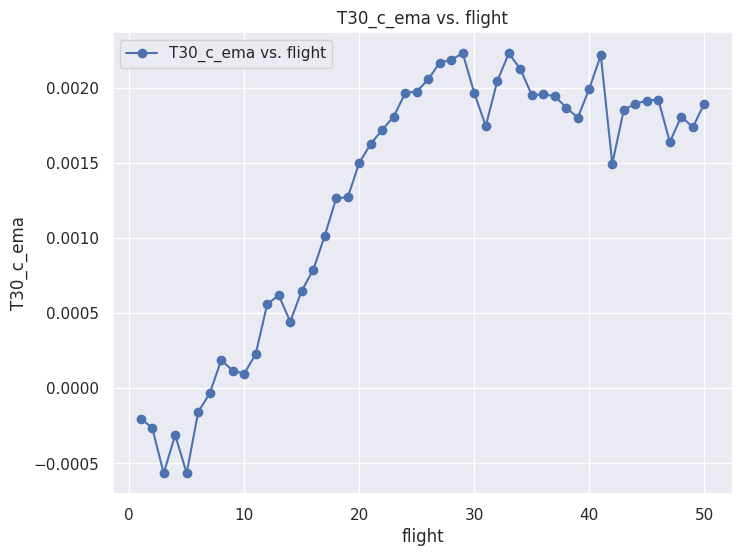

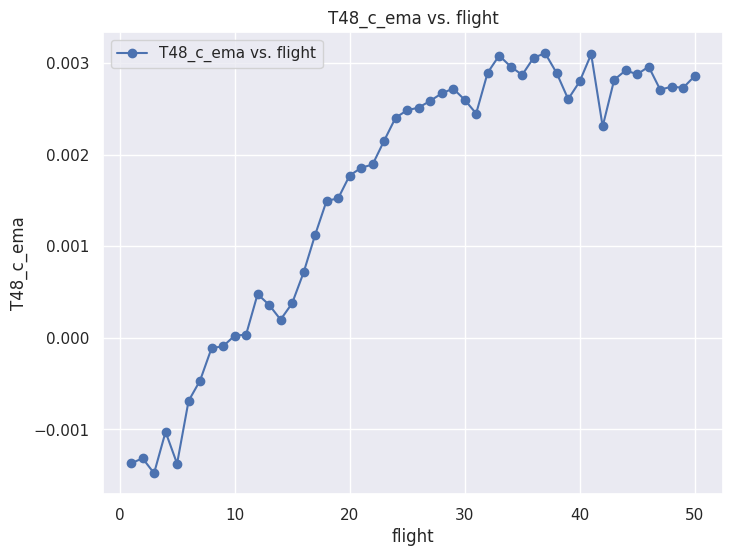

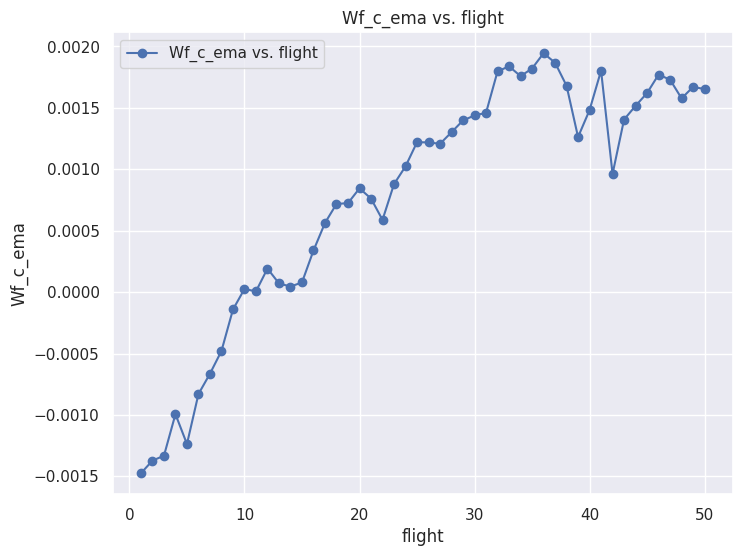

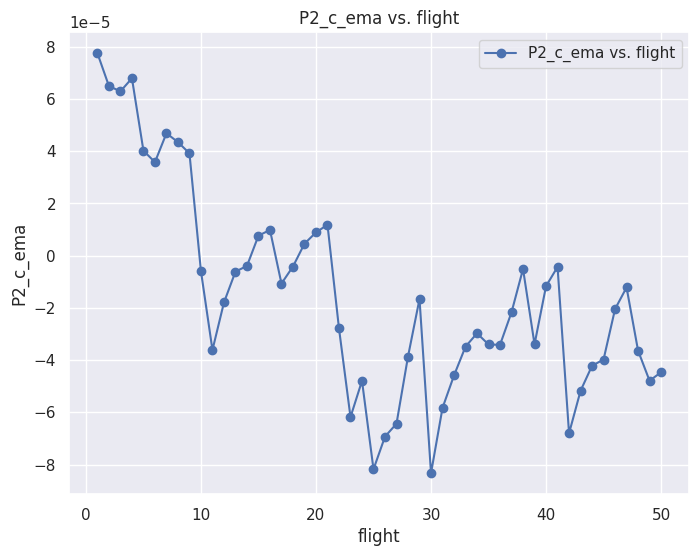

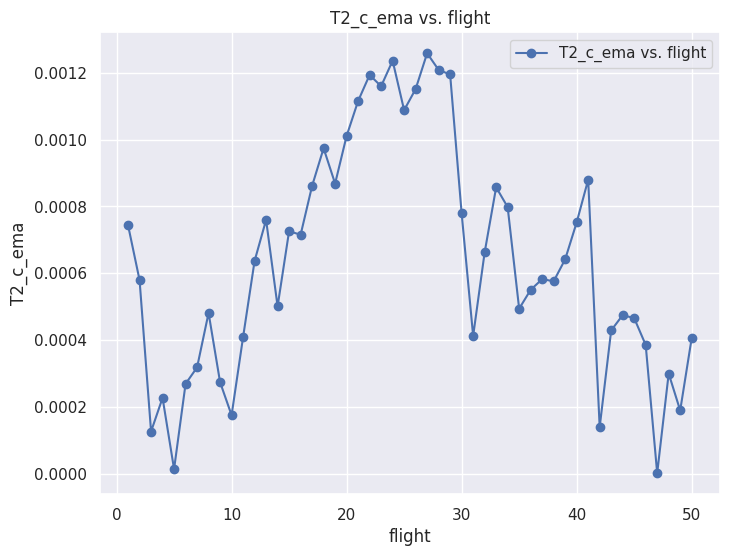

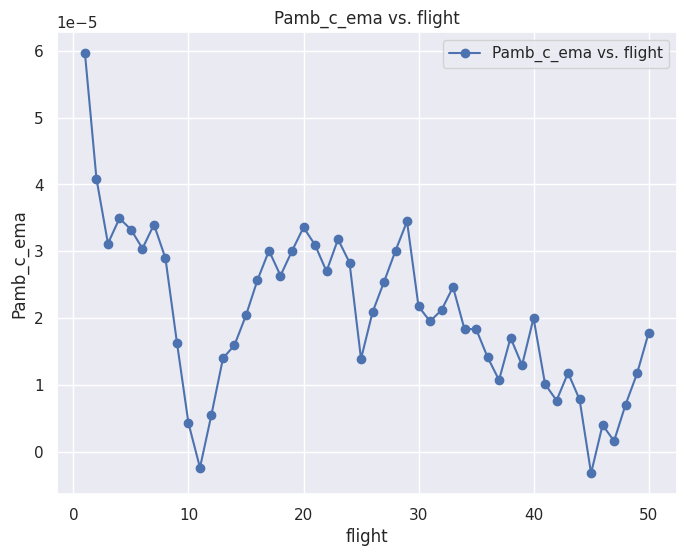

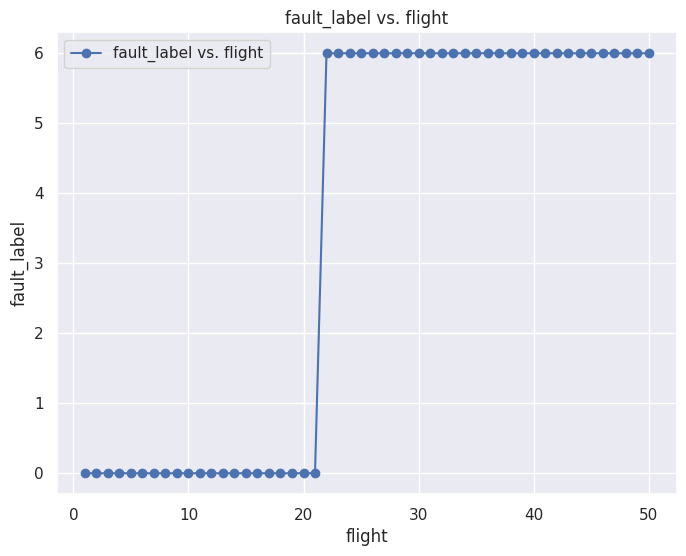

In [199]:
for column in data_total_with_labels_eval:
  visualize_param(data_total_with_labels_eval,200,column,"flight")

In [220]:
data_total_with_labels_eval = data_total_with_labels_eval.dropna(subset=['fault_label'])

In [221]:
X_eval = data_total_with_labels_eval.drop(columns=['engine', 'flight', 'fault_label'])
y_eval = data_total_with_labels_eval['fault_label']

In [222]:
#X_eval_array = X_eval.values
X_eval = scaler.transform(X_eval)
#X_eval_reshaped = X_eval_array.reshape(X_eval_array.shape[0], X_eval_array.shape[1], 1)

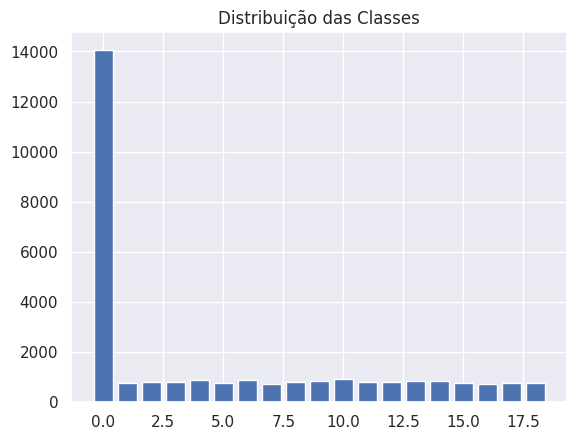

In [223]:
plt.bar(np.unique(y_eval), np.bincount(y_eval))
plt.title('Distribuição das Classes')
plt.show()

888/888 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


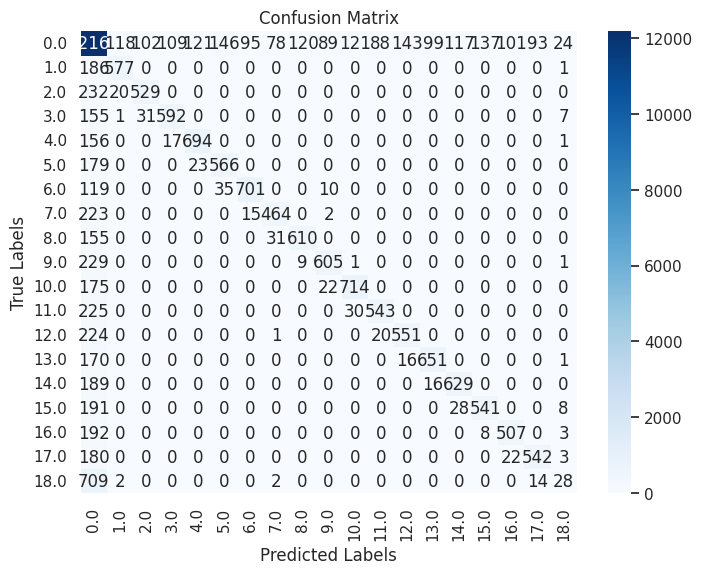

In [247]:
y_pred_eval = model_CNN.predict(X_eval)

y_pred_labels_eval = y_pred_eval.argmax(axis=1)

cm = confusion_matrix(y_eval, y_pred_labels_eval)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Diagnostic Matrix

In [184]:
def create_diagnostic_matrix(engines, flights, y_predicted):
    engines = engines.astype(int)
    flights = flights.astype(int)

    num_engines = len(set(engines))
    num_flights = flights.max()

    y_pred_labels = np.argmax(y_predicted, axis=1)

    diagnostic_matrix = diagnostic_matrix = y_pred_labels.reshape(num_engines, num_flights)

    return diagnostic_matrix

In [185]:
diagnostic_matrix = create_diagnostic_matrix(
    data_total_with_labels_eval["engine"],
    data_total_with_labels_eval["flight"],
    y_pred_eval
)

In [186]:
diagnostic_matrix[378]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0, 18,  0, 18,  0, 18, 18,
       18, 18,  0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0])

In [187]:
from scipy.io import savemat

# Data to save
data_to_save = {'diagnostic_matrix': diagnostic_matrix}

# Save to .mat file
savemat('diagnostic_matrix.mat', data_to_save)

print("Diagnostic matrix saved to diagnostic_matrix.mat")

Diagnostic matrix saved to diagnostic_matrix.mat


## Evaluation

In [188]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score


diagnostic_assessment = diagnostic_matrix


num_engines = len(data_total_with_labels_eval["engine"].astype(int))
num_flights = diagnostic_assessment.shape[1]  # Number of flights per engine
# Fault magnitude thresholds (small, medium, large)
sml_fault_mag = np.array([
    [3, 5],   # Fan (%)
    [3, 5],   # LPC (%)
    [3, 5],   # HPC (%)
    [3, 5],   # HPT (%)
    [3, 5],   # LPT (%)
    [3, 5],   # VSV (%)
    [7, 13],  # VBV (%)
    [4, 7],   # Nf (sigma)
    [4, 7],   # Nc (sigma)
    [4, 7],   # P24 (sigma)
    [4, 7],   # Ps30 (sigma)
    [4, 7],   # T24 (sigma)
    [4, 7],   # T30 (sigma)
    [4, 7],   # T48 (sigma)
    [4, 7],   # Wf36 (sigma)
    [4, 7],   # P2 (sigma)
    [4, 7],   # T2 (sigma)
    [7, 13]   # Pamb (sigma)
])

# Parameters
start_flight = 11
abrupt_window = 10
rapid_window = 6

# Initialize confusion matrices and counters
confusion_matrix_all = np.zeros((19, 19, 2, 3))  # True condition x Diagnosed condition x Evolution x Magnitude
confusion_matrix_no_fault = np.zeros((1, 19))  # For "No Fault" cases

tp_latency = np.zeros((19, 2, 3))
cc_latency = np.zeros((19, 2, 3))
tp_counter = np.zeros((19, 2, 3))
cc_counter = np.zeros((19, 2, 3))

# Ensure num_engines is correctly aligned with diagnostic_assessment
num_engines = diagnostic_assessment.shape[0]  # Match the first dimension of diagnostic_assessment

for i in range(num_engines):  # Iterate over valid engine indices
    true_fault_type = int(fault_params_df_eval.iloc[i, 0])
    fault_start = int(fault_params_df_eval.iloc[i, 1])
    fault_evolution = int(fault_params_df_eval.iloc[i, 2])
    fault_magnitude = fault_params_df_eval.iloc[i, 3]

    # 1. No Fault cases
    if true_fault_type == 0:
        for flight in range(start_flight, min(num_flights, fault_start)):
            diagnosed_fault = diagnostic_assessment[i, flight]
            column = 19 if diagnosed_fault == 0 else diagnosed_fault
            confusion_matrix_no_fault[0, column - 1] += 1

    # 2. Fault cases
    else:
        if fault_evolution == 0:  # Abrupt
            evolution_flag = 0
            diagnostic_window = range(fault_start, min(fault_start + abrupt_window, num_flights))
        else:  # Rapid
            evolution_flag = 1
            diagnostic_window = range(fault_start, min(fault_start + fault_evolution + rapid_window, num_flights))

        if abs(fault_magnitude) < sml_fault_mag[int(true_fault_type) - 1, 0]:
            magnitude_flag = 0  # Small
        elif abs(fault_magnitude) > sml_fault_mag[int(true_fault_type) - 1, 1]:
            magnitude_flag = 2  # Large
        else:
            magnitude_flag = 1  # Medium

        for flight in diagnostic_window:
            diagnosed_fault = diagnostic_assessment[i, flight]
            column = 19 if diagnosed_fault == 0 else diagnosed_fault
            confusion_matrix_all[int(true_fault_type) - 1, column - 1, evolution_flag, magnitude_flag] += 1

            if diagnosed_fault != 0:  # True positive
                tp_counter[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += 1
                tp_latency[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += flight - fault_start

                if diagnosed_fault == true_fault_type:  # Correct classification
                    cc_counter[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += 1
                    cc_latency[int(true_fault_type) - 1, evolution_flag, magnitude_flag] += flight - fault_start

confusion_matrix_abrupt = confusion_matrix_all[:, :, 0, :].sum(axis=2)
confusion_matrix_rapid = confusion_matrix_all[:, :, 1, :].sum(axis=2)

# Kappa Coefficients
def calculate_kappa(matrix):
    total = np.sum(matrix)
    observed_agreement = np.trace(matrix)
    expected_agreement = sum((np.sum(matrix, axis=0) * np.sum(matrix, axis=1)) / total)
    return (observed_agreement - expected_agreement) / (total - expected_agreement)

kappa_abrupt = calculate_kappa(confusion_matrix_abrupt)
kappa_rapid = calculate_kappa(confusion_matrix_rapid)

# Normalize Confusion Matrices
confusion_matrix_abrupt_normalized = np.zeros_like(confusion_matrix_abrupt, dtype=float)
confusion_matrix_rapid_normalized = np.zeros_like(confusion_matrix_rapid, dtype=float)

for i in range(confusion_matrix_abrupt.shape[0]):
    row_sum_abrupt = confusion_matrix_abrupt[i].sum()
    row_sum_rapid = confusion_matrix_rapid[i].sum()

    if row_sum_abrupt > 0:
        confusion_matrix_abrupt_normalized[i] = confusion_matrix_abrupt[i] / row_sum_abrupt
    else:
        confusion_matrix_abrupt_normalized[i] = np.nan  # Handle zero row

    if row_sum_rapid > 0:
        confusion_matrix_rapid_normalized[i] = confusion_matrix_rapid[i] / row_sum_rapid
    else:
        confusion_matrix_rapid_normalized[i] = np.nan  # Handle zero row
print("Kappa Coefficient (Abrupt):", kappa_abrupt)
print("Kappa Coefficient (Rapid):", kappa_rapid)

Kappa Coefficient (Abrupt): 0.028847813682111777
Kappa Coefficient (Rapid): 0.018766446208352095
